# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime

In [ ]:
from scipy.misc import imread, imresize

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())

In [4]:
len(train_doc)

663

In [5]:
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
len(val_doc)

100

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Images have two types of dimensions - either 360x360 or 120x160. So we will have to reshape all of them to same size of 120x160 using below function

In [6]:
def preprocess_image(image):
    if image.shape != [120, 160, 3]:
        image = tf.image.resize(image, [120, 160])
        image = tf.cast(image, tf.uint8)
    return(image/255)

In [7]:
def generator(source_path, folder_list, batch_size, img_idx):
    print( 'Source path = ', source_path, '; batch size =', batch_size, ' ; image indices = ' , img_idx)
    #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    # setting standard size for all the images.
    y=120  
    z=160
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches : total images devided by number of images taken. i.e. length of folder_list // batch_size
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # NOT USING imread. Using below code.
                    image_path = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    raw_image = tf.io.read_file(image_path) # reading imiage using tensorflow
                    dec_image = tf.image.decode_image(raw_image, channels=3) # decoding image using tensorflow
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # reshape the images if they are not of required size i.e. 120X160
                    new_image = preprocess_image(dec_image) # created finction to resize and normalize the image.
                    
                    batch_data[folder,idx,:,:,0] = new_image[:, :, 0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = new_image[:, :, 1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = new_image[:, :, 2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        rem_batches = len(folder_list) % batch_size  # remaining number of batches
        if rem_batches > 0: # we iterate over the number of batches
            batch_data = np.zeros((rem_batches,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_batches,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # NOT USING imread. Using below code.
                    image_path = source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    raw_image = tf.io.read_file(image_path) # reading imiage using tensorflow
                    dec_image = tf.image.decode_image(raw_image, channels=3) # decoding image using tensorflow
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # reshape the images if they are not of required size i.e. 120X160
                    new_image = preprocess_image(dec_image) # created finction to resize and normalize the image.
                    batch_data[folder,idx,:,:,0] = new_image[:, :, 0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = new_image[:, :, 1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = new_image[:, :, 2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
             
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [22]:
train_doc[1]

'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'

In [8]:
train_path = './Project_data/train'
val_path = './Project_data/val'

In [9]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [10]:
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 50


In [11]:
image_indices = list(range(1, 29, 3))
print ('# ', len(image_indices), ' image indices =', image_indices)

#  10  image indices = [1, 4, 7, 10, 13, 16, 19, 22, 25, 28]


In [12]:
num_classes = 5 # setting the number of classes for model
print('# num_classes : ', num_classes)

# num_classes :  5


In [13]:
input_shape = (len(image_indices), 120, 160, 3) # setting the input shape for model
print('# input_shape : ', input_shape)

# input_shape :  (10, 120, 160, 3)


In [14]:
batch_size = 16 # setting the batch_size for model
print('# batch_size : ', batch_size)

# batch_size :  16


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size, image_indices)
val_generator = generator(val_path, val_doc, batch_size, image_indices)

In [16]:
print(next(train_generator)[0].shape)

Source path =  ./Project_data/train ; batch size = 16  ; image indices =  [1, 4, 7, 10, 13, 16, 19, 22, 25, 28]
(16, 10, 120, 160, 3)


In [17]:
print(next(val_generator)[0].shape)

Source path =  ./Project_data/val ; batch size = 16  ; image indices =  [1, 4, 7, 10, 13, 16, 19, 22, 25, 28]
(16, 10, 120, 160, 3)


In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print('num_train_sequences:', num_train_sequences, 'batch_size:', batch_size, 'steps_per_epoch:', steps_per_epoch)
print('num_val_sequences:', num_val_sequences, 'batch_size:', batch_size, 'validation_steps:', validation_steps)

num_train_sequences: 663 batch_size: 16 steps_per_epoch: 42
num_val_sequences: 100 batch_size: 16 validation_steps: 7


#### Import Libraries

In [19]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
#write your model here

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [21]:
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [117]:

model1 = Sequential()
model1.add(Conv3D( 32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model1.add(MaxPooling3D())
model1.add(BatchNormalization())
model1.add(Conv3D( 64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model1.add(MaxPooling3D())
model1.add(BatchNormalization())
model1.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model1.add(MaxPooling3D())
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(GlobalAveragePooling3D())
model1.add(Dense(num_classes, activation='softmax'))

In [118]:
# setting higher learning rate for initial model.
optimiser = optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)                   │ (None, 10, 120, 160, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_18 (MaxPooling3D)      │ (None, 5, 60, 80, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 5, 60, 80, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 5, 60, 80, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_19 (MaxPooling3D)      │ (None, 2, 30, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 2, 30, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_22 (Conv3D)                   │ (None, 2, 30, 40, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_20 (MaxPooling3D)      │ (None, 1, 15, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 1, 15, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 15, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 280,837 (1.07 MB)

 Trainable params: 280,389 (1.07 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [119]:
model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4754 - loss: 1.2658
Epoch 1: saving model to Model Outputs/model_init_2024-12-0400_52_31.251488/model-00001-1.07838-0.55204-1.71815-0.31000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - categorical_accuracy: 0.4771 - loss: 1.2614 - val_categorical_accuracy: 0.3100 - val_loss: 1.7182 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7185 - loss: 0.7596
Epoch 2: saving model to Model Outputs/model_init_2024-12-0400_52_31.251488/model-00002-0.74153-0.72851-2.13749-0.21000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - categorical_accuracy: 0.7187 - loss: 0.7591 - val_categorical_accuracy: 0.2100 - val_loss: 2.1375 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7351 - loss: 0.6573
Epoch 3: saving model to Model Outputs/model_init_2024-12-0400_52_31.251488/model-00003-0.63371-0.75566-2.85906-0.21000.keras
42/42 ━━━━

In [120]:
## model not saved in history so taken values from above results.
train_acc = [0.4771, 	0.7187, 	0.7356, 	0.8291, 	0.8202, 	0.8568, 	0.8841, 	0.8677, 	0.8911, 	0.8779, 	0.8969, 	0.9053, 	0.9133, 	0.9432, 	0.9435, 	0.9433, 	0.9274, 	0.9451, 	0.9588, 	0.9581, 	0.9617, 	0.9433, 	0.9426, 	0.927, 	0.9474, 	0.9523, 	0.9553, 	0.9652, 	0.9656, 	0.9807, 	0.9613, 	0.9759, 	0.9623, 	0.9829, 	0.9929, 	0.978, 	0.9833, 	0.9879, 	0.9789, 	0.9923, 	0.9742, 	0.9854, 	0.9796, 	0.97, 	0.9836, 	0.9985, 	0.9869, 	0.9963, 	0.9975, 	0.9999]
train_loss= [1.2614, 	0.7591, 	0.6567, 	0.493, 	0.457, 	0.4202, 	0.3694, 	0.3554, 	0.3161, 	0.2907, 	0.2779, 	0.2866, 	0.2782, 	0.1928, 	0.1998, 	0.1581, 	0.1969, 	0.1576, 	0.166, 	0.153, 	0.1303, 	0.1574, 	0.1629, 	0.1778, 	0.1577, 	0.1328, 	0.1365, 	0.1235, 	0.1083, 	0.077, 	0.1249, 	0.0957, 	0.1278, 	0.0807, 	0.0418, 	0.0929, 	0.0584, 	0.0615, 	0.0829, 	0.0389, 	0.0824, 	0.0425, 	0.0598, 	0.0838, 	0.0546, 	0.0262, 	0.035, 	0.0162, 	0.0244, 	0.0199]
val_acc = [0.31, 	0.21, 	0.21, 	0.31, 	0.26, 	0.28, 	0.25, 	0.24, 	0.6, 	0.47, 	0.46, 	0.6, 	0.7, 	0.87, 	0.85, 	0.54, 	0.75, 	0.8, 	0.64, 	0.77, 	0.4, 	0.79, 	0.69, 	0.55, 	0.91, 	0.95, 	0.77, 	0.82, 	0.38, 	0.9, 	0.87, 	0.88, 	0.87, 	0.93, 	0.76, 	0.7, 	0.79, 	0.69, 	0.84, 	0.65, 	0.9, 	0.72, 	0.43, 	0.79, 	0.93, 	0.93, 	0.96, 	0.96, 	0.94, 	0.93]
val_loss = [1.7182, 	2.1375, 	2.8591, 	2.6158, 	3.1778, 	2.3567, 	4.3194, 	2.3293, 	0.88, 	2.0456, 	1.8506, 	0.9883, 	0.8131, 	0.4519, 	0.4359, 	2.4623, 	0.739, 	0.6966, 	1.1329, 	0.6309, 	4.1729, 	0.6244, 	0.8416, 	2.5448, 	0.2473, 	0.2552, 	0.653, 	0.3996, 	3.3316, 	0.2499, 	0.2839, 	0.2655, 	0.3463, 	0.2218, 	0.9329, 	1.057, 	0.5889, 	1.0485, 	0.4014, 	1.2884, 	0.3167, 	1.0953, 	4.1031, 	0.988, 	0.1607, 	0.1902, 	0.1076, 	0.1086, 	0.1265, 	0.159]

In [125]:
import matplotlib.pyplot as plt

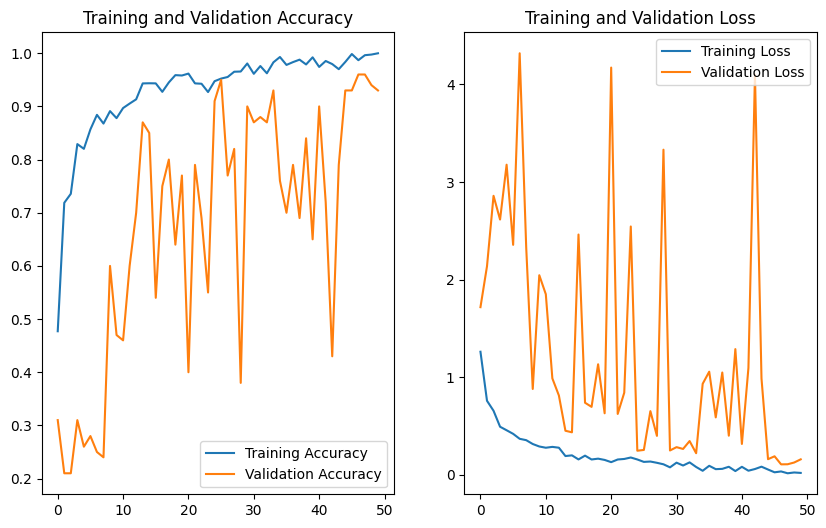

In [127]:
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model 1 Observations

**Accuracy**
1. Training accuracy steadily improves and plateaus around 90-95%.
2. Validation accuracy fluctuates significantly and does not follow a consistent improvement trend.
3. This shows model is **overfitting**.

**Loss**

1. Training loss decreases steadily, showing the model is learning well on the training data.
2. Validation loss fluctuates significantly and even spikes at multiple points, indicating instability in validation performance.
3. There are epochs where validation loss spikes while validation accuracy improves, suggesting label **noise or overfitting**.

In [ ]:
del model1

In [23]:
#Creating the basic CNN2D model with time distributed layer.
model2 = Sequential()
model2.add(Conv3D( 32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model2.add(MaxPooling3D())
model2.add(Dropout(0.2))
model2.add(Conv3D( 64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model2.add(MaxPooling3D())
model2.add(Dropout(0.2))
model2.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model2.add(MaxPooling3D())
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(GlobalAveragePooling3D())
model2.add(Dense(num_classes, activation='softmax'))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# setting higher learning rate for initial model.
optimiser = optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 10, 120, 160, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 5, 60, 80, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 60, 80, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 5, 60, 80, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 2, 30, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 30, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 2, 30, 40, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 1, 15, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 15, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 15, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 280,453 (1.07 MB)

 Trainable params: 280,197 (1.07 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [26]:
model2_history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4122 - loss: 2.4112
Epoch 1: saving model to Model Outputs/model2_init_2024-12-0421_02_08.546239/model-00001-2.06738-0.50377-2.09332-0.31000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - categorical_accuracy: 0.4143 - loss: 2.4032 - val_categorical_accuracy: 0.3100 - val_loss: 2.0933 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6351 - loss: 1.4649
Epoch 2: saving model to Model Outputs/model2_init_2024-12-0421_02_08.546239/model-00002-1.34449-0.65460-1.76159-0.47000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - categorical_accuracy: 0.6356 - loss: 1.4621 - val_categorical_accuracy: 0.4700 - val_loss: 1.7616 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6994 - loss: 1.1138
Epoch 3: saving model to Model Outputs/model2_init_2024-12-0421_02_08.546239/model-00003-1.05369-0.71192-1.59418-0.44000.keras
42/42 ━

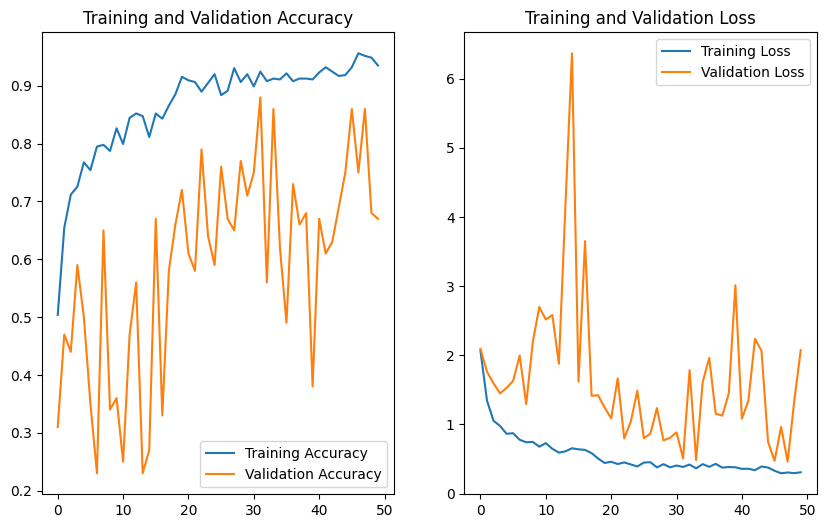

In [32]:
train_acc = model2_history.history['categorical_accuracy']
val_acc = model2_history.history['val_categorical_accuracy']
train_loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model 2 Observations

**Accuracy**
1. Training accuracy steadily improves and plateaus around 90-95%.
2. Validation accuracy fluctuates significantly and does not follow a consistent improvement trend.
3. **overfitting** can be one of the problem here. Another reason can be thata we have class imbalance or that there can be noise int the data or we have higher learning rate.

**Loss**

1. Training loss decreases steadily, showing the model is learning well on the training data.
2. Validation loss fluctuates significantly and even spikes at multiple points, indicating instability in validation performance.
3. There are epochs where validation loss spikes while validation accuracy improves, suggesting label **noise or overfitting**.

In [35]:
round(100*max(train_acc), 2)

95.63

##### model3

In [36]:
del model2
model3 = Sequential()
model3.add(Conv3D( 16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model3.add(MaxPooling3D())
model3.add(Dropout(0.2))
model3.add(Conv3D( 32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model3.add(MaxPooling3D())
model3.add(Dropout(0.2))
model3.add(Conv3D( 64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model3.add(MaxPooling3D())
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(GlobalAveragePooling3D())
model3.add(Dense(num_classes, activation='softmax'))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# setting lower learning rate for this model.
optimiser = optimizers.Adam(learning_rate=0.0005)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 10, 120, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 5, 60, 80, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5, 60, 80, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 5, 60, 80, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 2, 30, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 30, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 2, 30, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 1, 15, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 15, 20, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 15, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1, 15, 20, 128)      │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,749 (311.52 KB)

 Trainable params: 79,621 (311.02 KB)

 Non-trainable params: 128 (512.00 B)

None


In [38]:
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
callbacks_list = [checkpoint, LR]

In [39]:
model3_history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2496 - loss: 2.2241
Epoch 1: saving model to Model Outputs/model3_init_2024-12-0423_58_06.989415/model-00001-2.05526-0.32127-2.02423-0.37000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - categorical_accuracy: 0.2513 - loss: 2.2202 - val_categorical_accuracy: 0.3700 - val_loss: 2.0242 - learning_rate: 5.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5060 - loss: 1.6192
Epoch 2: saving model to Model Outputs/model3_init_2024-12-0423_58_06.989415/model-00002-1.56313-0.48718-1.84095-0.53000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - categorical_accuracy: 0.5056 - loss: 1.6179 - val_categorical_accuracy: 0.5300 - val_loss: 1.8409 - learning_rate: 5.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6430 - loss: 1.3288
Epoch 3: saving model to Model Outputs/model3_init_2024-12-0423_58_06.989415/model-00003-1.27228-0.62896-1.70036-0.48000.keras


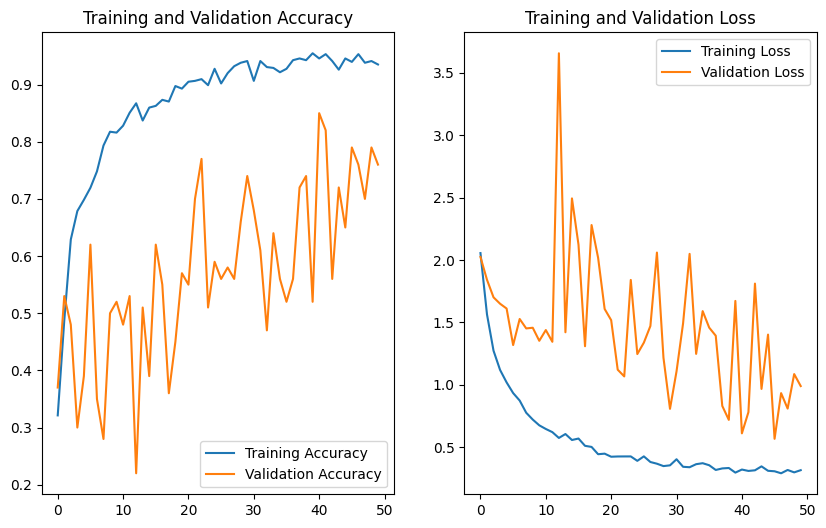

In [40]:
train_acc = model3_history.history['categorical_accuracy']
val_acc = model3_history.history['val_categorical_accuracy']
train_loss = model3_history.history['loss']
val_loss = model3_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
del model3

In [48]:

model4 = Sequential()
model4.add(Conv3D( 32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model4.add(MaxPooling3D())
model4.add(Conv3D( 64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model4.add(MaxPooling3D())
model4.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model4.add(MaxPooling3D())
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0005)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_15 (Conv3D)                   │ (None, 10, 120, 160, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_14 (MaxPooling3D)      │ (None, 5, 60, 80, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_16 (Conv3D)                   │ (None, 5, 60, 80, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_15 (MaxPooling3D)      │ (None, 2, 30, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 2, 30, 40, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 1, 15, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 15, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 15, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │       4,915,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,195,781 (19.82 MB)

 Trainable params: 5,195,525 (19.82 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [49]:
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
callbacks_list = [checkpoint, LR]

In [50]:
callbacks_list

In [54]:
model4_history = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4245 - loss: 1.9319
Epoch 1: saving model to Model Outputs/model4_init_2024-12-0710_49_39.698045/model-00001-1.41821-0.51282-1.45447-0.29000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - categorical_accuracy: 0.4266 - loss: 1.9199 - val_categorical_accuracy: 0.2900 - val_loss: 1.4545 - learning_rate: 5.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7682 - loss: 0.6078
Epoch 2: saving model to Model Outputs/model4_init_2024-12-0710_49_39.698045/model-00002-0.51571-0.80995-1.34585-0.39000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - categorical_accuracy: 0.7692 - loss: 0.6056 - val_categorical_accuracy: 0.3900 - val_loss: 1.3458 - learning_rate: 5.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8587 - loss: 0.3961
Epoch 3: saving model to Model Outputs/model4_init_2024-12-0710_49_39.698045/model-00003-0.35792-0.86425-1.25554-0.61000.keras

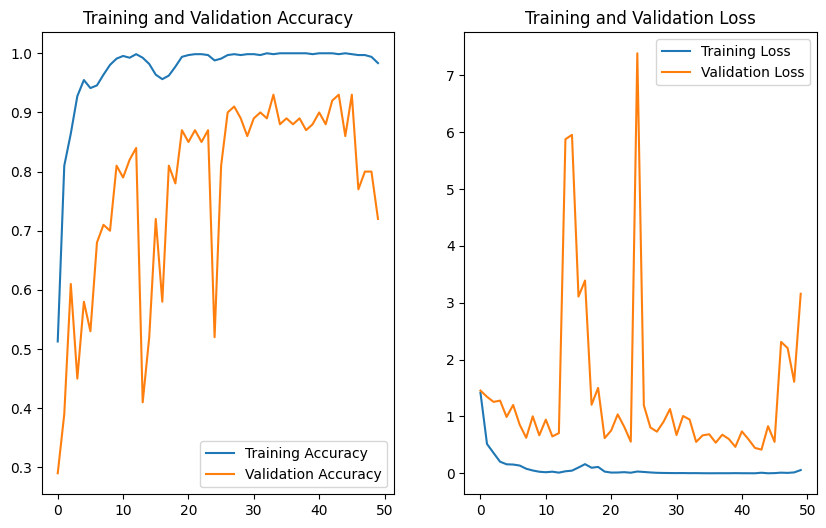

In [55]:
train_acc = model4_history.history['categorical_accuracy']
val_acc = model4_history.history['val_categorical_accuracy']
train_loss = model4_history.history['loss']
val_loss = model4_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
del model4
model5 = Sequential()
model5.add(Conv3D( 32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model5.add(MaxPooling3D())
model5.add(BatchNormalization())
model5.add(Dropout(0.25))
model5.add(Conv3D( 64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model5.add(MaxPooling3D())
model5.add(BatchNormalization())
model5.add(Dropout(0.25))
model5.add(Flatten())
model5.add(Dense( 64, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_25 (Conv3D)                   │ (None, 10, 120, 160, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 5, 60, 80, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 60, 80, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 5, 60, 80, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_26 (Conv3D)                   │ (None, 5, 60, 80, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_25 (MaxPooling3D)      │ (None, 2, 30, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 30, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 2, 30, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 153600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │       9,830,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,889,157 (37.72 MB)

 Trainable params: 9,888,965 (37.72 MB)

 Non-trainable params: 192 (768.00 B)

None


In [61]:
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model5_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
callbacks_list = [checkpoint, LR]

model5_history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3178 - loss: 3.2249
Epoch 1: saving model to Model Outputs/model5_init_2024-12-0712_44_44.842842/model-00001-2.29828-0.34087-2.35099-0.23000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - categorical_accuracy: 0.3183 - loss: 3.2033 - val_categorical_accuracy: 0.2300 - val_loss: 2.3510 - learning_rate: 2.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4124 - loss: 1.4420
Epoch 2: saving model to Model Outputs/model5_init_2024-12-0712_44_44.842842/model-00002-1.44026-0.38311-4.62023-0.21000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - categorical_accuracy: 0.4117 - loss: 1.4420 - val_categorical_accuracy: 0.2100 - val_loss: 4.6202 - learning_rate: 2.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3552 - loss: 1.4525
Epoch 3: saving model to Model Outputs/model5_init_2024-12-0712_44_44.842842/model-00003-1.37398-0.37858-5.28630-0.21000.keras


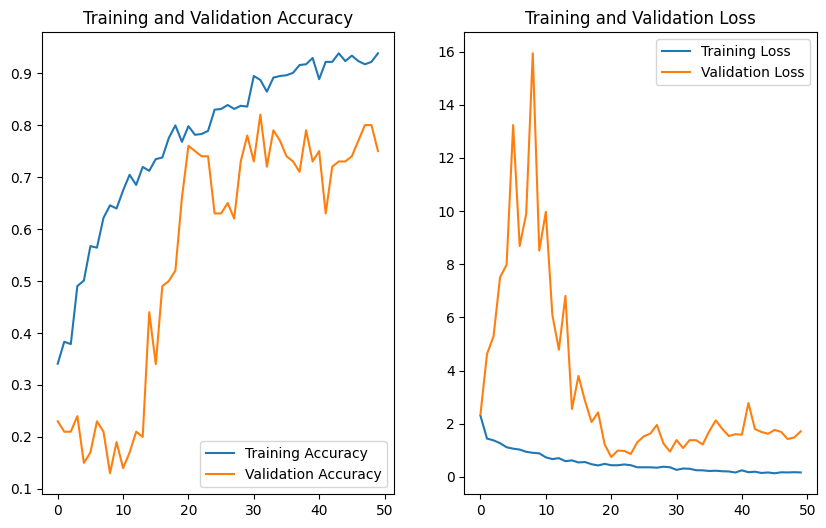

In [62]:
train_acc = model5_history.history['categorical_accuracy']
val_acc = model5_history.history['val_categorical_accuracy']
train_loss = model5_history.history['loss']
val_loss = model5_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Conv 2D with Time distributed LSTM

In [20]:
input_shape

(10, 120, 160, 3)

In [21]:
batch_size

16

In [26]:
from keras.layers import Conv2D, MaxPooling2D, LSTM

In [29]:
# Time Distributed Conv2D with LSTM - base Model
del model5
input_layer = Input(shape=input_shape)
x = TimeDistributed(Conv2D(16, kernel_size=(2,2), activation='relu'))(input_layer)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(Conv2D(32, kernel_size=(2,2), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(64, return_sequences=False)(x)
output_layer = Dense(5, activation='softmax')(x)
model6 = Model(inputs=input_layer, outputs=output_layer)
optimiser = optimizers.Adam(learning_rate=0.0002)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 10, 120, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 10, 119, 159, 16)    │             208 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 10, 59, 79, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 10, 58, 78, 32)      │           2,080 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 10, 29, 39, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 10, 36192)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │       9,281,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,284,405 (35.42 MB)

 Trainable params: 9,284,405 (35.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
num_epochs = 20
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model6_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks_list = [checkpoint, LR]

model6_history = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2397 - loss: 1.7507
Epoch 1: saving model to Model Outputs/model6_init_2024-12-0812_47_37.451313/model-00001-1.61329-0.29110-1.52874-0.27000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - categorical_accuracy: 0.2409 - loss: 1.7475 - val_categorical_accuracy: 0.2700 - val_loss: 1.5287 - learning_rate: 2.0000e-04
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4204 - loss: 1.4282
Epoch 2: saving model to Model Outputs/model6_init_2024-12-0812_47_37.451313/model-00002-1.39447-0.45852-1.31997-0.50000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - categorical_accuracy: 0.4212 - loss: 1.4274 - val_categorical_accuracy: 0.5000 - val_loss: 1.3200 - learning_rate: 2.0000e-04
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5914 - loss: 1.1345
Epoch 3: saving model to Model Outputs/model6_init_2024-12-0812_47_37.451313/model-00003-1.09046-0.59729-1.08303-0.53000.kera

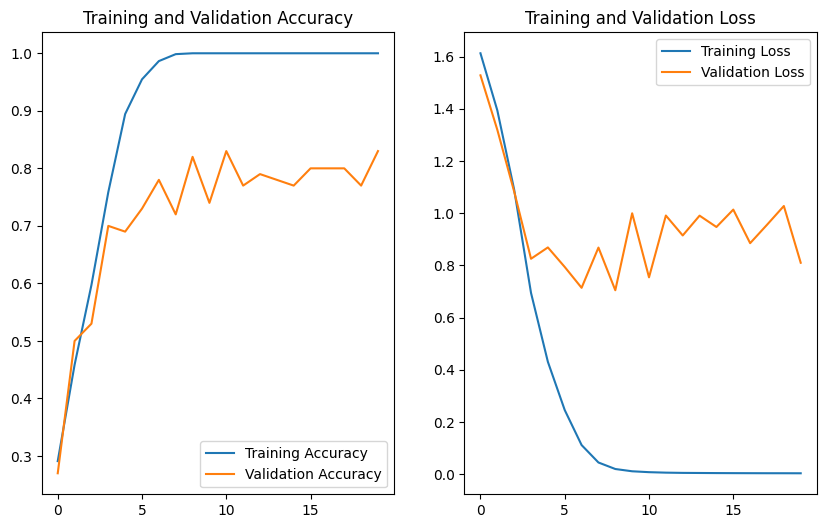

In [32]:
train_acc = model6_history.history['categorical_accuracy']
val_acc = model6_history.history['val_categorical_accuracy']
train_loss = model6_history.history['loss']
val_loss = model6_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model is overfitting

In [34]:


# Time Distributed Conv2D with LSTM - base Model
del model6
input_layer = Input(shape=input_shape)
x = TimeDistributed(Conv2D(32, kernel_size=(2,2), activation='relu'))(input_layer)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = Dropout(0.3)(x)
x = TimeDistributed(Conv2D(64, kernel_size=(2,2), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = Dropout(0.3)(x) 
x = TimeDistributed(Conv2D(128, kernel_size=(2,2), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=False)(x)
output_layer = Dense(5, activation='softmax')(x)
model7 = Model(inputs=input_layer, outputs=output_layer)
optimiser = optimizers.Adam(learning_rate=0.0005)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 10, 120, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, 10, 119, 159, 32)    │             416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, 10, 59, 79, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, 10, 59, 79, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 59, 79, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 10, 58, 78, 64)      │           8,256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 10, 29, 39, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 10, 29, 39, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 29, 39, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 10, 28, 38, 128)     │          32,896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, 10, 14, 19, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, 10, 34048)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │      17,498,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,541,221 (66.91 MB)

 Trainable params: 17,541,029 (66.91 MB)

 Non-trainable params: 192 (768.00 B)

None


In [35]:
num_epochs = 30
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model7_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks_list = [checkpoint, LR]

model7_history = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.1993 - loss: 1.7649 
Epoch 1: saving model to Model Outputs/model7_init_2024-12-0815_05_30.200815/model-00001-1.68070-0.20664-1.60359-0.23000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 525s 12s/step - categorical_accuracy: 0.1995 - loss: 1.7629 - val_categorical_accuracy: 0.2300 - val_loss: 1.6036 - learning_rate: 5.0000e-04
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.2522 - loss: 1.5737
Epoch 2: saving model to Model Outputs/model7_init_2024-12-0815_05_30.200815/model-00002-1.58441-0.26395-1.60254-0.24000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 420s 10s/step - categorical_accuracy: 0.2525 - loss: 1.5739 - val_categorical_accuracy: 0.2400 - val_loss: 1.6025 - learning_rate: 5.0000e-04
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2914 - loss: 1.5918
Epoch 3: saving model to Model Outputs/model7_init_2024-12-0815_05_30.200815/model-00003-1.58740-0.30920-1.59426-0.26000

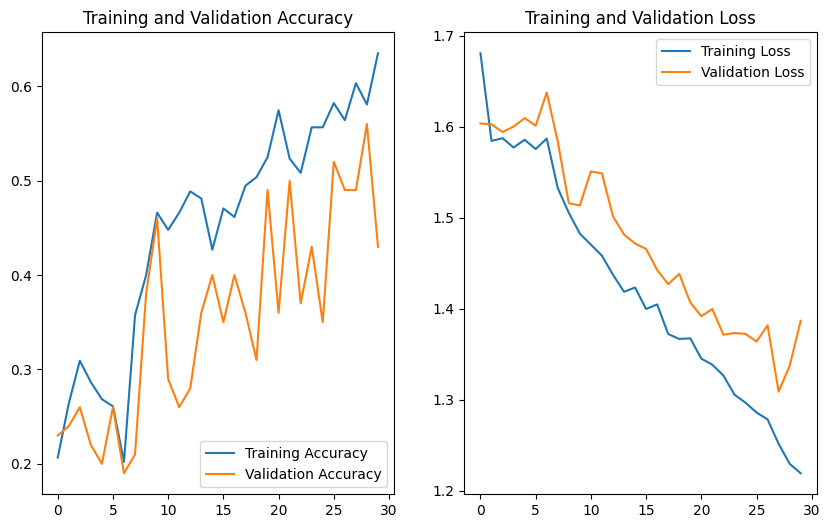

In [36]:
train_acc = model7_history.history['categorical_accuracy']
val_acc = model7_history.history['val_categorical_accuracy']
train_loss = model7_history.history['loss']
val_loss = model7_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Conv 2D with Time distributed GRU

In [38]:


del model7
input_layer = Input(shape=input_shape)
x = TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu'))(input_layer)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Dropout(0.2))(x)
x = TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Dropout(0.2))(x)
x = TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Flatten())(x)
x = GRU(64, dropout=0.25)(x)
output_layer = Dense(5, activation='softmax')(x)
model8 = Model(inputs=input_layer, outputs=output_layer)
optimiser = optimizers.Adam(learning_rate=0.001)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 10, 120, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_49                  │ (None, 10, 118, 158, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_50                  │ (None, 10, 59, 79, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_51                  │ (None, 10, 59, 79, 16)      │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_52                  │ (None, 10, 59, 79, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_53                  │ (None, 10, 57, 77, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_54                  │ (None, 10, 28, 38, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_55                  │ (None, 10, 28, 38, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_56                  │ (None, 10, 28, 38, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_57                  │ (None, 10, 26, 36, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_58                  │ (None, 10, 13, 18, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_59                  │ (None, 10, 13, 18, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_60                  │ (None, 10, 14976)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │       2,888,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 2,912,421 (11.11 MB)

 Trainable params: 2,912,197 (11.11 MB)

 Non-trainable params: 224 (896.00 B)

None


In [39]:
num_epochs = 30
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model8_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks_list = [checkpoint, LR]

model8_history = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4121 - loss: 1.6992
Epoch 1: saving model to Model Outputs/model8_init_2024-12-0819_50_06.838378/model-00001-1.28665-0.53394-1.97798-0.27000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - categorical_accuracy: 0.4149 - loss: 1.6896 - val_categorical_accuracy: 0.2700 - val_loss: 1.9780 - learning_rate: 0.0010
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7709 - loss: 0.6856
Epoch 2: saving model to Model Outputs/model8_init_2024-12-0819_50_06.838378/model-00002-0.64541-0.76772-1.48918-0.47000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - categorical_accuracy: 0.7708 - loss: 0.6846 - val_categorical_accuracy: 0.4700 - val_loss: 1.4892 - learning_rate: 0.0010
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8493 - loss: 0.4641
Epoch 3: saving model to Model Outputs/model8_init_2024-12-0819_50_06.838378/model-00003-0.43785-0.85520-1.14435-0.55000.keras
42/42 

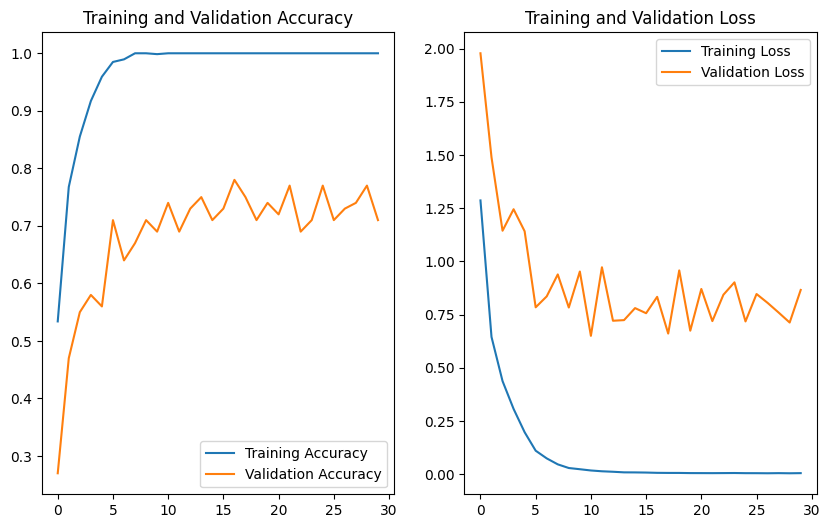

In [40]:
train_acc = model8_history.history['categorical_accuracy']
val_acc = model8_history.history['val_categorical_accuracy']
train_loss = model8_history.history['loss']
val_loss = model8_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model is overfitting. 

    1. Increasing dropout
    2. increasing kernel size.
    3. Adding Global Pooling Instead of Flatten:
    4. learning_rate 0.0001

In [45]:
from keras.layers import GlobalAveragePooling2D

del model8
input_layer = Input(shape=input_shape)
x = TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu'))(input_layer)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Dropout(0.3))(x)
x = TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Dropout(0.2))(x)
x = TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(GlobalAveragePooling2D())(x)
x = GRU(32, dropout=0.3)(x)
output_layer = Dense(5, activation='softmax')(x)
model9 = Model(inputs=input_layer, outputs=output_layer)
optimiser = optimizers.Adam(learning_rate=0.0001)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 10, 120, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_84                  │ (None, 10, 118, 158, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_85                  │ (None, 10, 59, 79, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_86                  │ (None, 10, 59, 79, 16)      │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_87                  │ (None, 10, 59, 79, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_88                  │ (None, 10, 57, 77, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_89                  │ (None, 10, 28, 38, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_90                  │ (None, 10, 28, 38, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_91                  │ (None, 10, 28, 38, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_92                  │ (None, 10, 26, 36, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_93                  │ (None, 10, 13, 18, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_94                  │ (None, 10, 13, 18, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_95                  │ (None, 10, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 33,605 (131.27 KB)

 Trainable params: 33,381 (130.39 KB)

 Non-trainable params: 224 (896.00 B)

None


In [46]:
num_epochs = 50
curr_dt_time = datetime.datetime.now()
model_name = 'Model Outputs/' + 'model9_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks_list = [checkpoint, LR]

model9_history = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2685 - loss: 1.5453
Epoch 1: saving model to Model Outputs/model9_init_2024-12-0821_27_00.317724/model-00001-1.47421-0.34238-1.66943-0.23000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - categorical_accuracy: 0.2702 - loss: 1.5436 - val_categorical_accuracy: 0.2300 - val_loss: 1.6694 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4651 - loss: 1.3501
Epoch 2: saving model to Model Outputs/model9_init_2024-12-0821_27_00.317724/model-00002-1.33900-0.44495-1.82796-0.24000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - categorical_accuracy: 0.4646 - loss: 1.3498 - val_categorical_accuracy: 0.2400 - val_loss: 1.8280 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4605 - loss: 1.2702
Epoch 3: saving model to Model Outputs/model9_init_2024-12-0821_27_00.317724/model-00003-1.27479-0.44796-1.76207-0.20000.kera

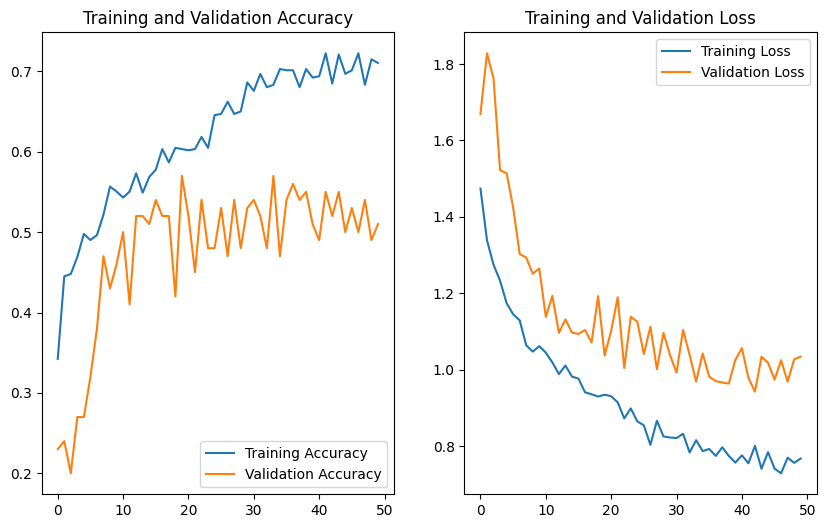

In [47]:
train_acc = model9_history.history['categorical_accuracy']
val_acc = model9_history.history['val_categorical_accuracy']
train_loss = model9_history.history['loss']
val_loss = model9_history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
def generator_new(source_path, folder_list, batch_size, img_num=20, height=120, width=120, augment=False):
  
    print('Source path =', source_path, '; batch size =', batch_size)
    framespervideo = 30
    #img_idx = np.round(np.linspace(0,framespervideo-1,img_num)).astype(int)  # Assuming we are selecting the first `x` frames for simplicity.
    while True:
        t = np.random.permutation(folder_list)  # Shuffle the folder list.
        num_batches = len(folder_list) // batch_size  # Calculate the number of full batches.
        #num_batches = num_train_sequences // batch_size 
        img_idx = np.round(np.linspace(0,framespervideo-1,img_num)).astype(int)  # Assuming we are selecting the first `x` frames for simplicity.
    
        
        for batch in range(num_batches):  # Iterate over the number of batches.
            # Initialize the batch data and labels.
            batch_data = np.zeros((batch_size, img_num, height, width, 3))  # (batch_size, num_frames, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # Assuming 5 classes for one-hot encoding.

            for folder in range(batch_size):  # Iterate over each folder in the batch.
                folder_name = t[folder + (batch * batch_size)].strip().split(';')[0]  # Extract folder name.
                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])  # Extract label.
                folder_path = os.path.join(source_path, folder_name)
                imgs = sorted(os.listdir(folder_path))  # List all images in the folder (sorted for consistency).

                for idx, item in enumerate(img_idx):  # Iterate over selected frame indices.
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imageio.imread(image_path).astype(np.float32)  # Read the image.
                    if augment:
                        #image = resize(image, (height, width), anti_aliasing=True)
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)  
                            
                    image_resized = resize(image, (height, width), anti_aliasing=True)

                    # Normalize the image and assign it to the appropriate channel.
                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255.0  # Red channel.
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255.0  # Green channel.
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255.0  # Blue channel.

                # Assign the label to the one-hot encoded batch_labels.
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels  # Yield the batch data and labels.

        # Process any remaining data that doesn't fit into a full batch.
        remaining_folders = len(folder_list) % batch_size
        if remaining_folders > 0:
            batch_data = np.zeros((remaining_folders, img_num, height, width, 3))  # Initialize for the remaining data.
            batch_labels = np.zeros((remaining_folders, 5))  # Adjust batch size for leftovers.

            for folder in range(remaining_folders):  # Process leftover folders.
                folder_name = t[folder + (num_batches * batch_size)].strip().split(';')[0]
                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                folder_path = os.path.join(source_path, folder_name)
                imgs = sorted(os.listdir(folder_path))

                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    if augment:
                        #image = resize(image, (height, width), anti_aliasing=True)
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)  
                            
                    image_resized = resize(image, (height, width), anti_aliasing=True)

                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255.0

                batch_labels[folder, label] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [16]:
def get_callbacks_list(modelspecs):
    global callbacks_list
    model_name = 'model_' + str(modelspecs) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    #filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    filepath = model_name + 'model-{epoch:02d}.h5'


    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)

    LR = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,    # Reduce learning rate by this factor
                           patience=5,    # Number of epochs with no improvement before reducing LR
                           verbose=1, 
                           min_lr=1e-5)   # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [17]:
def get_Steps():
    global steps_per_epoch
    global validation_steps
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

## Model 10

In [ ]:
del model9

In [51]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model10 = Sequential()

model10.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(num_frames, 120, 120, 3)))
model10.add(Activation('relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(64, (3, 3, 3), padding='same'))
model10.add(Activation('relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(128, (3, 3, 3), padding='same'))
model10.add(Activation('relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(256, (3, 3, 3), padding='same'))    
model10.add(Activation('relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Flatten())
model10.add(Dense(128))
model10.add(Activation('relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.25))

model10.add(Dense(128))
model10.add(Activation('relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.25))

model10.add(Dense(num_classes))
model10.add(Activation('softmax'))


# epochs = 20
# batch size = 10
# num_frames per video = 20


In [52]:
optimiser = tf.keras.optimizers.Adam() #write your optimizer
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_5 (Activation)   (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 20, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                              

In [54]:

get_callbacks_list('model10')
get_Steps()

train_generator = generator_new(train_path, train_doc, batch_size, img_num=num_frames)
val_generator   = generator_new(val_path, val_doc, batch_size, img_num=num_frames)

In [55]:
history = model10.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
19/67 [=======>......................] - ETA: 1:11 - loss: 2.1153 - categorical_accuracy: 0.3105
Epoch 00001: saving model to model_model10_2024-12-1009_54_15.429748/model-01.h5
39/67 [================>.............] - ETA: 41s - loss: 1.7550 - categorical_accuracy: 0.4000
Epoch 00001: saving model to model_model10_2024-12-1009_54_15.429748/model-01.h5
59/67 [=========================>....] - ETA: 11s - loss: 1.6803 - categorical_accuracy: 0.4068
Epoch 00001: saving model to model_model10_2024-12-1009_54_15.429748/model-01.h5
67/67 [==============================] - 111s 2s/step - loss: 1.6513 - categorical_accuracy: 0.4118 - val_loss: 2.5295 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
12/67 [====>.........................] - ETA: 1:07 - loss: 1.3440 - categorical_accuracy: 0.5000
Epoch 00002: saving model to model_model10_2024-12-1009_54_15.429748/model-02.h5
32/67 [=============>..............

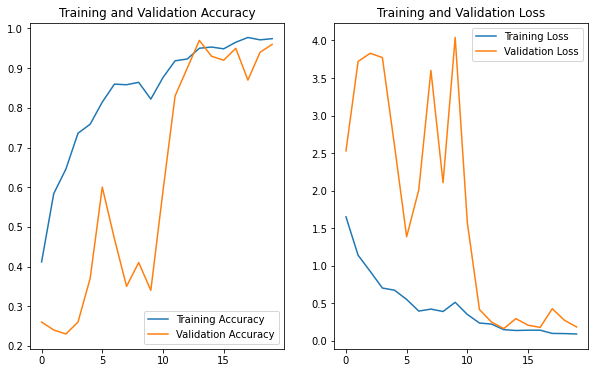

In [56]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
from keras.applications import mobilenet
from tensorflow.keras.applications import ResNet50

def transferlearning_model(isgru=False, num_lstm_gru=128, dense_nodes=128, img_num=20, height=120, width=120, isResnet = False):
    if(isResnet):
        transfermodel = ResNet50(weights='imagenet', include_top=False)
    else:
        transfermodel = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained model: ", len(transfermodel.layers))

    for layer in transfermodel.layers:
        layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(transfermodel,input_shape=(img_num, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(keras.layers.MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (isgru):
        model.add(GRU(num_lstm_gru))
    else:
        model.add(LSTM(num_lstm_gru))
    model.add(Dropout(0.25))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

In [21]:
del model10
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
model11 = transferlearning_model(isgru=False, img_num=num_frames)
print(model11.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)    

In [26]:
get_callbacks_list("model_20_retrain_mobilenet_lstm")

get_Steps()

train_generator = generator_new(train_path, train_doc, batch_size, img_num=num_frames)
val_generator   = generator_new(val_path, val_doc, batch_size, img_num=num_frames)

In [27]:
history = model11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
19/67 [=======>......................] - ETA: 6:25 - loss: 0.0130 - categorical_accuracy: 0.9974
Epoch 00001: saving model to model_1_model_20_retrain_mobilenet_lstm_2024-12-1009_54_15.429748/model-01.h5
39/67 [================>.............] - ETA: 3:40 - loss: 0.0115 - categorical_accuracy: 0.9975
Epoch 00001: saving model to model_1_model_20_retrain_mobilenet_lstm_2024-12-1009_54_15.429748/model-01.h5
59/67 [=========================>....] - ETA: 1:02 - loss: 0.0090 - categorical_accuracy: 0.9980
Epoch 00001: saving model to model_1_model_20_retrain_mobilenet_lstm_2024-12-1009_54_15.429748/model-01.h5
67/67 [==============================] - 601s 9s/step - loss: 0.0081 - categorical_accuracy: 0.9983 - val_loss: 0.2164 - val_categorical_accuracy: 0.9400 - lr: 0.0010
Epoch 2/20
12/67 [====>.........................] - ETA: 7:04 - loss: 0.0010 - categorical_accuracy: 1.0000
Epoch 00002: saving model to model_1_model_20_retrain_mobilenet_lstm_2024-12-1009_54_15.429748/model-0

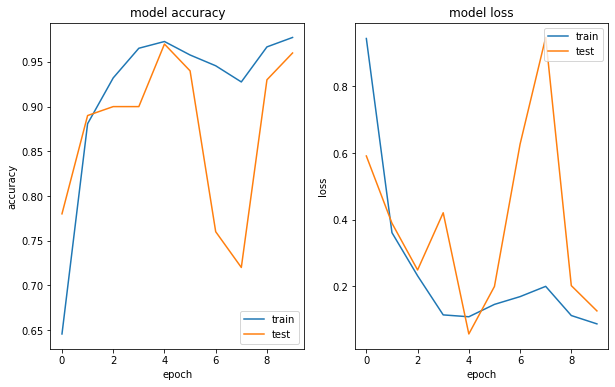

In [47]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='train')
plt.plot(epochs_range, val_acc, label='test')
plt.legend(loc='lower right')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='train')
plt.plot(epochs_range, val_loss, label='test')
plt.legend(loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


# Model 12

In [42]:
del model11
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 15
print ('# num frames per video =', num_frames)
model12 = transferlearning_model(isgru=True, img_num=num_frames)
print(model12.summary())

# epochs = 10
# batch size = 10
# num frames per video = 15
Number of layers in the pretrained mobilenet model:  86
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 1024)         0         
 stributed) 

In [43]:
get_callbacks_list("model_15_retrain_mobilenet_gru")

get_Steps()

train_generator = generator_new(train_path, train_doc, batch_size, img_num=num_frames)
val_generator   = generator_new(val_path, val_doc, batch_size, img_num=num_frames)

In [44]:
history = model12.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 10
Epoch 1/10
 9/67 [===>..........................] - ETA: 46s - loss: 1.8088 - categorical_accuracy: 0.3111
Epoch 00001: saving model to model_model_15_retrain_mobilenet_gru_2024-12-1009_54_15.429748/model-01.h5
19/67 [=======>......................] - ETA: 45s - loss: 1.5144 - categorical_accuracy: 0.3895
Epoch 00001: saving model to model_model_15_retrain_mobilenet_gru_2024-12-1009_54_15.429748/model-01.h5
29/67 [===========>..................] - ETA: 38s - loss: 1.3556 - categorical_accuracy: 0.4655
Epoch 00001: saving model to model_model_15_retrain_mobilenet_gru_2024-12-1009_54_15.429748/model-01.h5
39/67 [================>.............] - ETA: 28s - loss: 1.1835 - categorical_accuracy: 0.5385
Epoch 00001: saving model to model_model_15_retrain_mobilenet_gru_2024-12-1009_54_15.429748/model-01.h5
49/67 [====================>.........] - ETA: 18s - loss: 1.0942 - categorical_accuracy: 0.5755
Epoch 00001: saving model t

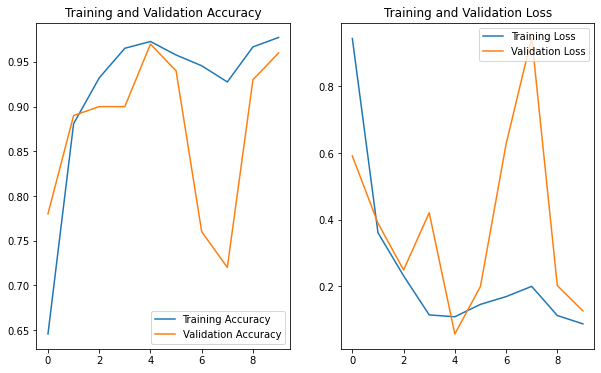

In [46]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
del model12

# Model 13

In [61]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
model13 = transferlearning_model(isgru=False, isResnet=True, img_num=num_frames)
print(model13.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
94781440/94765736 [==============================] - 6s 0us/step
Number of layers in the pretrained model:  175
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 4, 4, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (

In [62]:
get_callbacks_list("model_20_retrain_resnet_lstm")

get_Steps()

train_generator = generator_new(train_path, train_doc, batch_size, img_num=num_frames)
val_generator   = generator_new(val_path, val_doc, batch_size, img_num=num_frames)

In [63]:
history = model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
19/67 [=======>......................] - ETA: 1:06 - loss: 1.6886 - categorical_accuracy: 0.2579
Epoch 00001: saving model to model_model_20_retrain_resnet_lstm_2024-12-1009_54_15.429748/model-01.h5


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


39/67 [================>.............] - ETA: 38s - loss: 1.5972 - categorical_accuracy: 0.2949
Epoch 00001: saving model to model_model_20_retrain_resnet_lstm_2024-12-1009_54_15.429748/model-01.h5
59/67 [=========================>....] - ETA: 10s - loss: 1.5815 - categorical_accuracy: 0.3017
Epoch 00001: saving model to model_model_20_retrain_resnet_lstm_2024-12-1009_54_15.429748/model-01.h5
67/67 [==============================] - 114s 2s/step - loss: 1.5767 - categorical_accuracy: 0.3017 - val_loss: 1.4939 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
12/67 [====>.........................] - ETA: 1:06 - loss: 1.3809 - categorical_accuracy: 0.3583
Epoch 00002: saving model to model_model_20_retrain_resnet_lstm_2024-12-1009_54_15.429748/model-02.h5
32/67 [=============>................] - ETA: 44s - loss: 1.4327 - categorical_accuracy: 0.3562
Epoch 00002: saving model to model_model_20_retrain_resnet_lstm_2024-12-1009_54_15.429748/model-02.h5
52/67 [======================

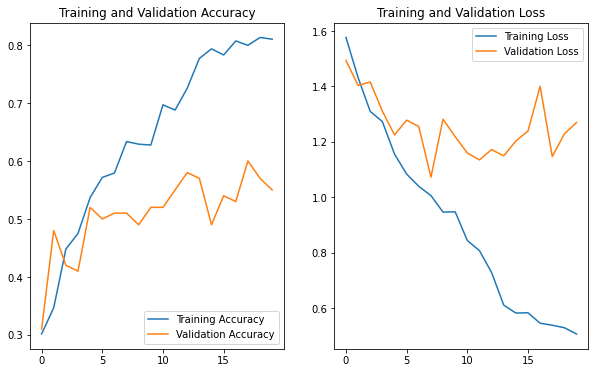

In [64]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
del model13

In [66]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
model14 = transferlearning_model(isgru=True, isResnet=True, img_num=num_frames)
print(model14.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained model:  175
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 20, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 4, 4, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 8192)         0         
 stributed)          

In [67]:
get_callbacks_list("model_20_retrain_resnet_gru")

get_Steps()

train_generator = generator_new(train_path, train_doc, batch_size, img_num=num_frames)
val_generator   = generator_new(val_path, val_doc, batch_size, img_num=num_frames)

In [68]:
history = model14.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
19/67 [=======>......................] - ETA: 1:05 - loss: 1.7726 - categorical_accuracy: 0.2000
Epoch 00001: saving model to model_model_20_retrain_resnet_gru_2024-12-1009_54_15.429748/model-01.h5
39/67 [================>.............] - ETA: 36s - loss: 1.6865 - categorical_accuracy: 0.2282
Epoch 00001: saving model to model_model_20_retrain_resnet_gru_2024-12-1009_54_15.429748/model-01.h5
59/67 [=========================>....] - ETA: 10s - loss: 1.6325 - categorical_accuracy: 0.2508
Epoch 00001: saving model to model_model_20_retrain_resnet_gru_2024-12-1009_54_15.429748/model-01.h5
67/67 [==============================] - 109s 2s/step - loss: 1.6340 - categorical_accuracy: 0.2579 - val_loss: 1.5313 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/20
12/67 [====>.........................] - ETA: 1:09 - loss: 1.3463 - categorical_accuracy: 0.4667
Epoch 00002: saving model to model_model_20_retrain_resn

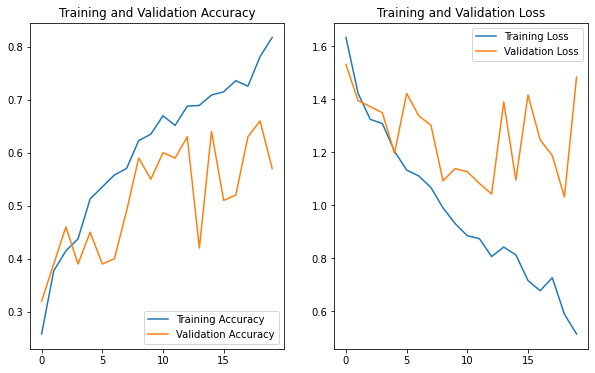

In [69]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
del model14

In [46]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)

model15 = mobilenet_RNN_GRU_LSTM(gru=True, num_images=num_frames)
print (model15.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
17235968/17225924 [==============================] - 2s 0us/step
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 trib

In [47]:
get_callbacks_list("model_20_retrain_mobilenet_gru")

get_Steps()
train_generator = generator_new(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generator_new(val_path, val_doc, batch_size, num_images=num_frames)

In [48]:
history = model15.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2274 - categorical_accuracy: 0.4857
Epoch 00001: val_loss improved from inf to 0.83716, saving model to model_20_retrain_mobilenet_gru_2024-12-0707_14_50.181326/model-00001-1.22739-0.48567-0.83716-0.66000.h5
67/67 [==============================] - 231s 3s/step - loss: 1.2274 - categorical_accuracy: 0.4857 - val_loss: 0.8372 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5009 - categorical_accuracy: 0.8235
Epoch 00002: val_loss did not improve from 0.83716
67/67 [==============================] - 225s 3s/step - loss: 0.5009 - categorical_accuracy: 0.8235 - val_loss: 0.9320 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3574 - categorical_accuracy: 0.8899
Epoch 00003: val_loss improved from 0.83716 to 0.30486, saving model to model_20_retrain_mobilenet_gru_2024-12-0707_14_50.181

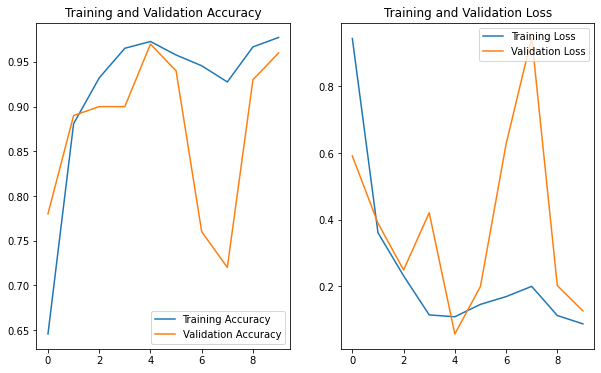

In [46]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()